#### loading data

In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('Data/sensor.csv')

df.shape

(220320, 55)

In [45]:
df.info

<bound method DataFrame.info of         Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0                0  2018-04-01 00:00:00   2.465394   47.09201  53.211800   
1                1  2018-04-01 00:01:00   2.465394   47.09201  53.211800   
2                2  2018-04-01 00:02:00   2.444734   47.35243  53.211800   
3                3  2018-04-01 00:03:00   2.460474   47.09201  53.168400   
4                4  2018-04-01 00:04:00   2.445718   47.13541  53.211800   
...            ...                  ...        ...        ...        ...   
220315      220315  2018-08-31 23:55:00   2.407350   47.69965  50.520830   
220316      220316  2018-08-31 23:56:00   2.400463   47.69965  50.564240   
220317      220317  2018-08-31 23:57:00   2.396528   47.69965  50.520830   
220318      220318  2018-08-31 23:58:00   2.406366   47.69965  50.520832   
220319      220319  2018-08-31 23:59:00   2.396528   47.69965  50.520832   

        sensor_03   sensor_04  sensor_05  sensor_06  se

To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook.

#### prepare data

In [46]:
# Replace null values with -1
df = df.fillna(df.mean(axis=1))

# Remove low-quality columns
df.drop(['sensor_15', 'sensor_50'], inplace=True, axis=1)

# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set timestamp as the index
df = df.set_index('timestamp')

# Resample the data to a lower frequency (e.g., daily mean)
df_resampled = df.resample('D').mean()

# Handle missing values in the resampled data (interpolation)
df_resampled = df_resampled.interpolate(method='linear')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15640\3995545299.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean(axis=1))


#### Scale Data

In [47]:
# Apply feature scaling (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_resampled)

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

# Calculate the outlier fraction
normal_count = len(df[df['machine_status'] == 'NORMAL'])
outliers_fraction = min(0.01, 1 - normal_count / len(df))

# Implement the anomaly detection algorithms
isolation_forest = IsolationForest(contamination=outliers_fraction)
one_class_svm = OneClassSVM(nu=outliers_fraction)
local_outlier_factor = LocalOutlierFactor(contamination=outliers_fraction)
robust_covariance = EllipticEnvelope(contamination=outliers_fraction)

algorithms = [
    ("Isolation Forest", isolation_forest),
    ("One-Class SVM", one_class_svm),
    ("Local Outlier Factor", local_outlier_factor),
    ("Robust covariance", robust_covariance)
]

for name, algorithm in algorithms:
    print(f"Running {name}...")
    
    # Fit the algorithm on the preprocessed data
    #algorithm.fit(X_scaled)
    
    # Predict outliers/anomalies
    #y_pred = algorithm.predict(df_resampled)
    
    #use this code of https://github.com/fenna/BFVM23DATASCNC5/blob/main/Study_Cases/Study_Case_Anomaly_Detection.ipynb after some bug on the implemented code in above commented
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(df_resampled)
    else:
        y_pred = algorithm.fit(X_scaled).predict(X_scaled)
    
    # Reshape y_pred to match the dataframe shape
    y_pred = y_pred.reshape(-1, 1)

    # Add the predictions to the dataframe
    df_resampled[name] = y_pred
    
    # Evaluate the performance of the algorithm
    anomalies_detected = df_resampled[df_resampled[name] == -1]
    print(f"Number of anomalies detected by {name}: {len(anomalies_detected)}")
    print("-" * 50)


Running Isolation Forest...
Number of anomalies detected by Isolation Forest: 2
--------------------------------------------------
Running One-Class SVM...
Number of anomalies detected by One-Class SVM: 22
--------------------------------------------------
Running Local Outlier Factor...
Number of anomalies detected by Local Outlier Factor: 2
--------------------------------------------------
Running Robust covariance...
Number of anomalies detected by Robust covariance: 2
--------------------------------------------------


In [51]:
preprocess_File = 'Data/preprocessed_data.csv'

# Save the preprocessed data to a new CSV file
df_resampled.to_csv(preprocess_File, index=False)

#### pllot sensor status

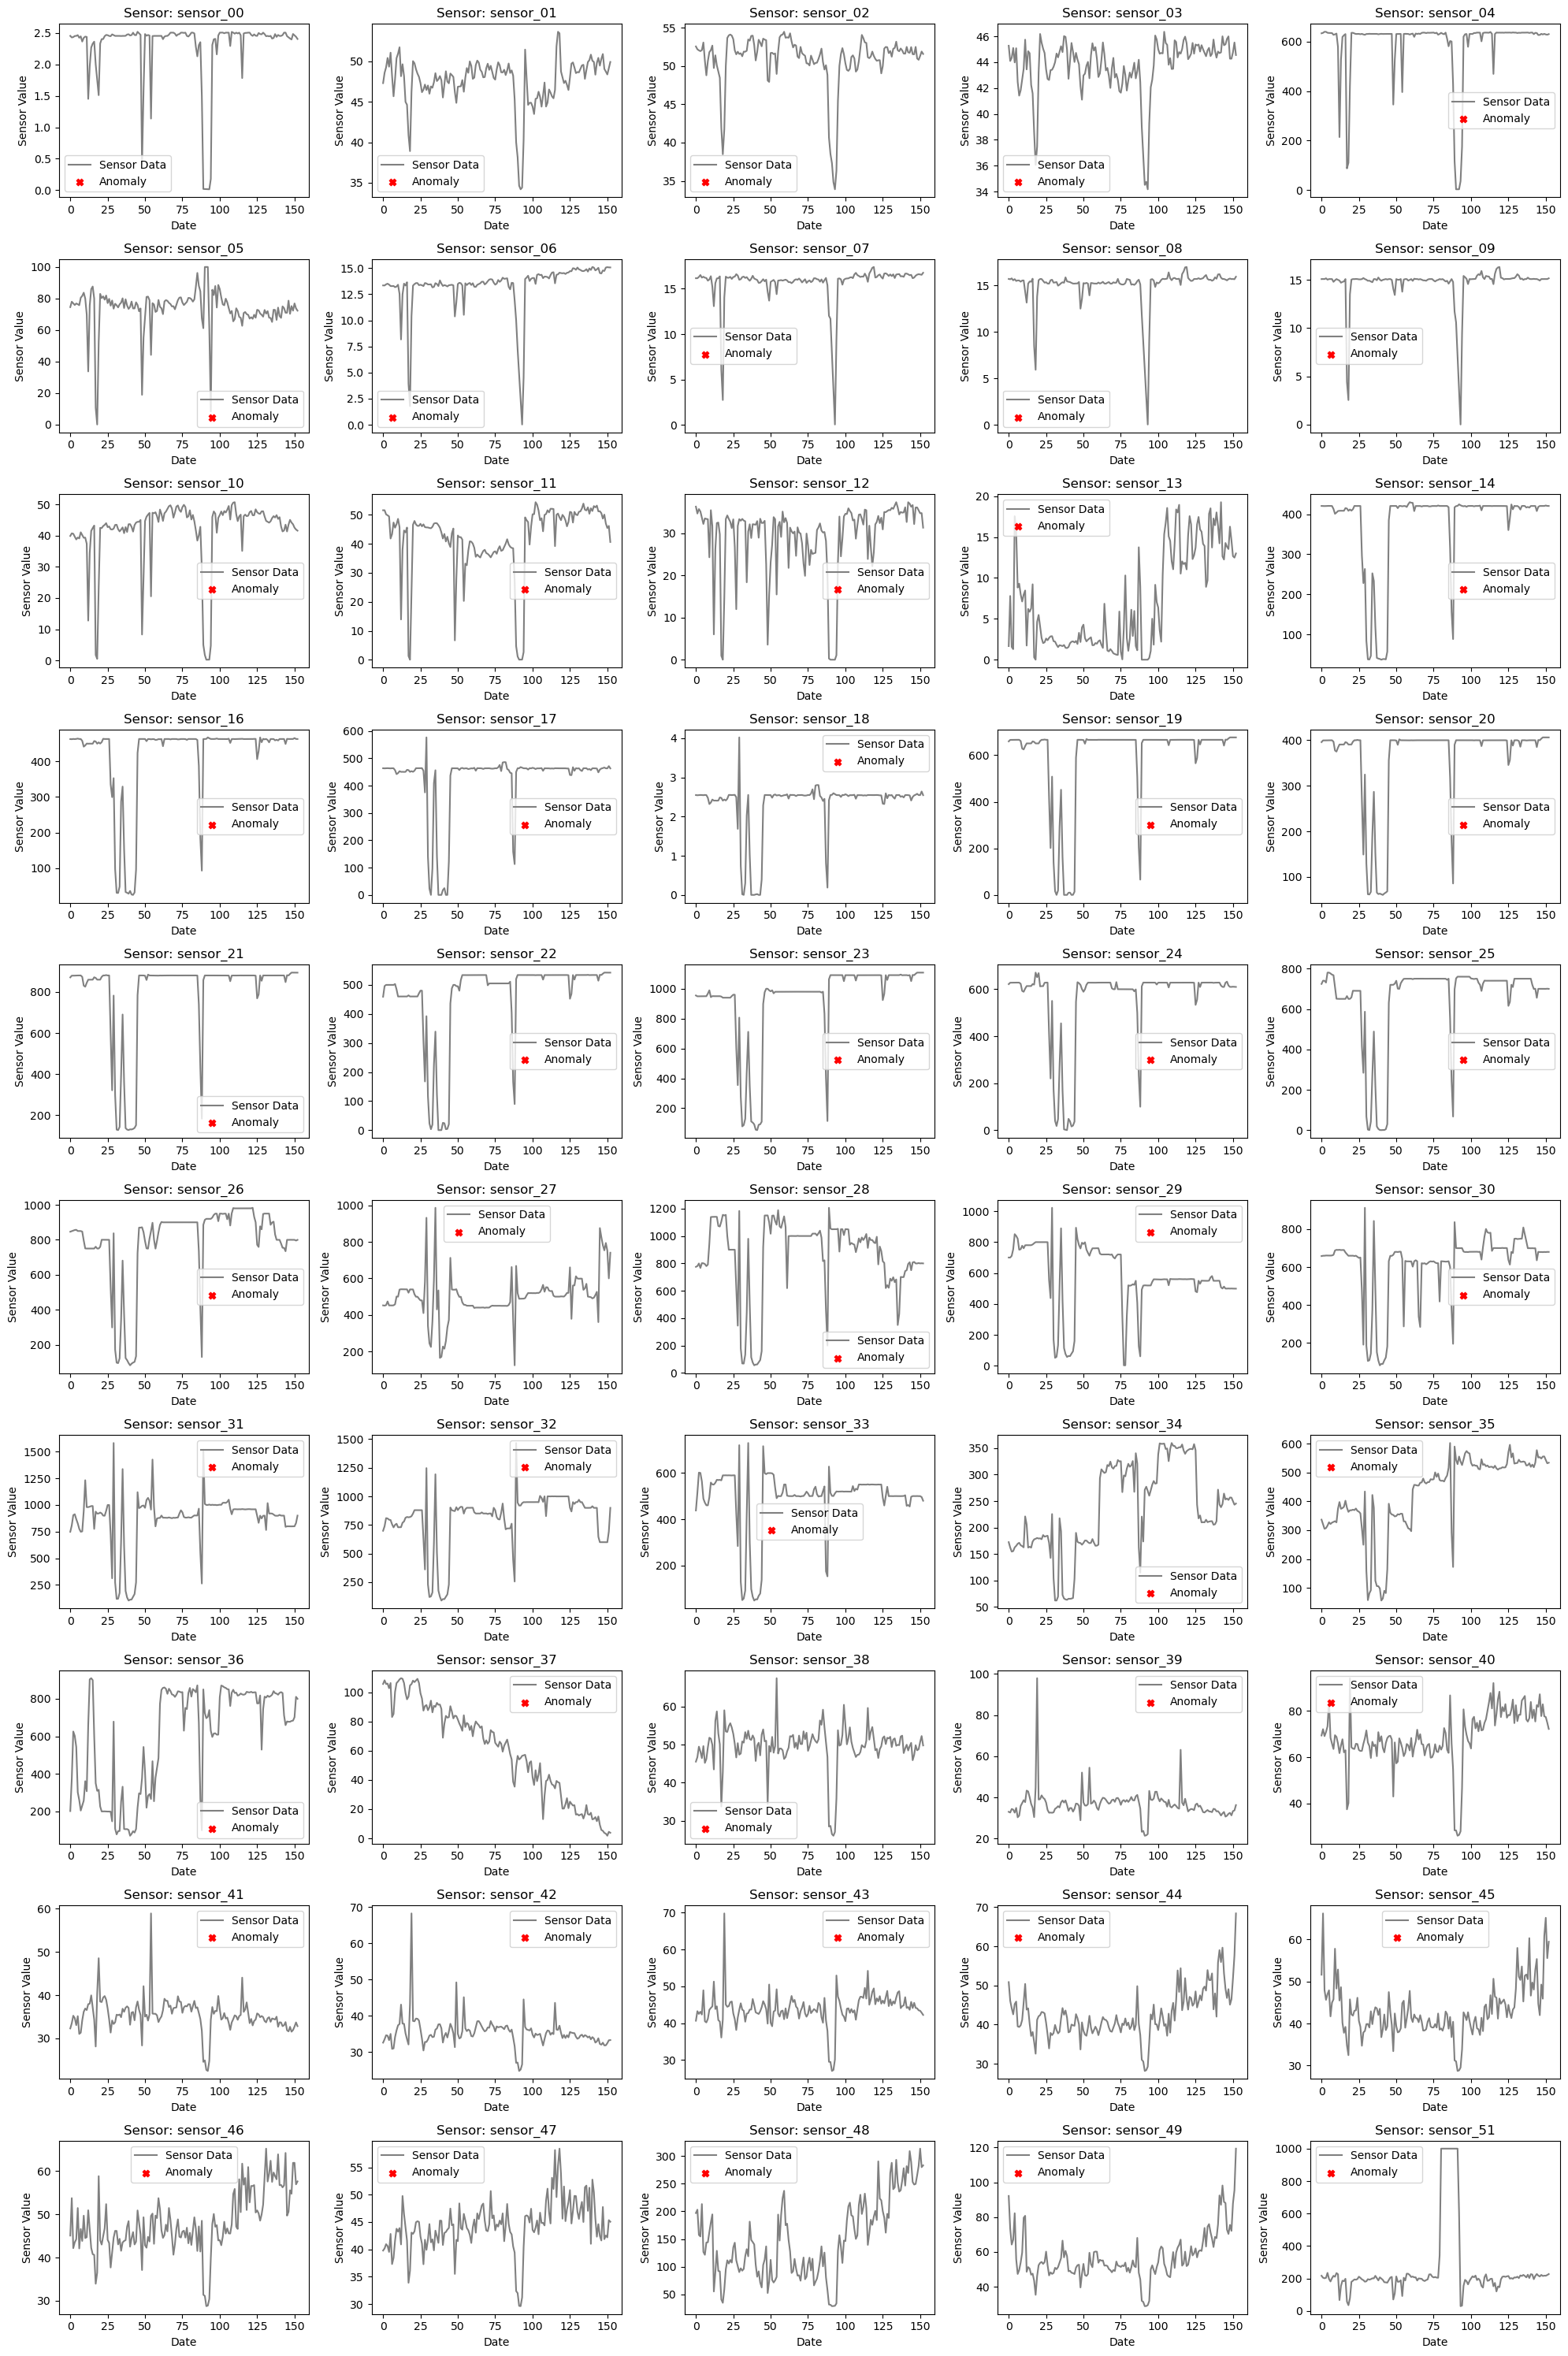

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the preprocessed data
df_resampled = pd.read_csv(preprocess_File)

# Get the list of sensor columns
sensor_columns = df_resampled.columns[1:-1]  # Exclude the timestamp and machine_status columns

# Set the number of rows and columns for subplots
num_rows = 10 
num_cols = 5 
total_plots = num_rows * num_cols
num_plots = min(total_plots, len(sensor_columns))

# subplots for each sensor
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))

# Iterate each sensor column and plot the data
for i, sensor_column in enumerate(sensor_columns[:num_plots]):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]
    ax.plot(df_resampled.index, df_resampled[sensor_column], color='grey', label='Sensor Data')
    ax.scatter(df_resampled[df_resampled[sensor_column] == -1].index,
               df_resampled[df_resampled[sensor_column] == -1][sensor_column],
               color='red', marker='X', label='Anomaly')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sensor Value')
    ax.set_title('Sensor: ' + sensor_column)
    ax.legend()

# Hide empty subplots
if num_plots < total_plots:
    for i in range(num_plots, total_plots):
        axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()
